In [1]:
from model import WordAudioSiameseNetwork
from loss import TripletLoss
from dataset import WordAudioDataset
from data_prep import prepare_zsl_split_word_audio
from transforms import get_transforms
from model_manager import ModelManager
from utils import *

/home/audio_dev/anaconda3/envs/jc_audio_dl/lib/python3.7/site-packages/requests/__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.6) doesn't match a supported version!
  RequestsDependencyWarning,


In [2]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle

## Model preparation

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
siamese_network = WordAudioSiameseNetwork().to(device)
triplet_loss = TripletLoss(0.5).to(device)
_, mel_transform = get_transforms()

In [5]:
optimizer_siamese = optim.Adam(siamese_network.parameters(), lr=0.01)
exp_lr_scheduler = ReduceLROnPlateau(
    optimizer_siamese, 
    mode='min', 
    factor=0.2, 
    patience=5, 
    verbose=True
)

In [6]:
curr_model = ModelManager(
    siamese_network, 
    triplet_loss, 
    optimizer_siamese, 
    exp_lr_scheduler, 
    device
)

In [7]:
curr_model.load_model('./checkpoints/word_audio_221129/w_ep-00195_l-0.0308.pth')

Loading model done: ./checkpoints/word_audio_221129/w_ep-00195_l-0.0308.pth


## Data split preparation

In [8]:
(
    seen_word_classes,
    seen_audio_X_train, 
    seen_audio_y_train, 
    seen_audio_X_test, 
    seen_audio_y_test,
    unseen_word_classes,
    unseen_audio_X_train, 
    unseen_audio_y_train, 
    unseen_audio_X_test, 
    unseen_audio_y_test,
    inst_word_emb_dict
) = prepare_zsl_split_word_audio()

## 1. Seen class prediction

In [9]:
seen_word_audio_dataset_tr = WordAudioDataset(
    audio_path_list = seen_audio_X_train,
    audio_label_list = seen_audio_y_train,
    audio_transform = mel_transform,
    curr_word_classes = seen_word_classes,
    word_emb_dict = inst_word_emb_dict
)
seen_word_audio_dataset_ts = WordAudioDataset(
    audio_path_list = seen_audio_X_test,
    audio_label_list = seen_audio_y_test,
    audio_transform = mel_transform,
    curr_word_classes = seen_word_classes,
    word_emb_dict = inst_word_emb_dict
)

In [10]:
seen_word_audio_dataloaders = {}
seen_word_audio_dataloaders['train'] = DataLoader(
    seen_word_audio_dataset_tr,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)
seen_word_audio_dataloaders['test'] = DataLoader(
    seen_word_audio_dataset_ts,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)

In [11]:
(
    seen_tr_audio_embs, 
    seen_tr_word_embs, 
    seen_tr_labels, 
    seen_tr_loss
) = curr_model.infer_all(seen_word_audio_dataloaders, 'train')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1738/1738 [01:21<00:00, 21.28it/s]

train Loss: 0.0254


In [12]:
(
    seen_ts_audio_embs, 
    seen_ts_word_embs, 
    seen_ts_labels, 
    seen_ts_loss
) = curr_model.infer_all(seen_word_audio_dataloaders, 'test')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:21<00:00, 20.61it/s]

test Loss: 0.0333


In [13]:
seen_class_to_audio_embs, seen_class_to_word_embs = defaultdict(list), defaultdict(list)
for i in tqdm(range(seen_tr_audio_embs.shape[0])):
    seen_class_to_audio_embs[seen_tr_labels[i]].append(seen_tr_audio_embs[i])
    seen_class_to_word_embs[seen_tr_labels[i]].append(seen_tr_word_embs[i])

for i in range(len(list(seen_class_to_audio_embs.keys()))):
    print(seen_word_classes[i], len(seen_class_to_audio_embs[i]), len(seen_class_to_word_embs[i]))    
    
seen_class_to_mean_audio_emb, seen_class_to_mean_word_emb = {}, {}
for _c in seen_class_to_audio_embs:
    seen_class_to_mean_audio_emb[_c] = np.mean(seen_class_to_audio_embs[_c], axis=0)
    seen_class_to_mean_word_emb[_c] = seen_class_to_word_embs[_c][0] # same embeddings

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1738/1738 [00:00<00:00, 586224.40it/s]

horn 108 108
violin 228 228
flute 96 96
contrabass 247 247
trombone 92 92
cello 232 232
clarinet 100 100
oboe 84 84
accordion 551 551


### 1-1. Test set audio to seen word class prediction (supervised learning evaluation)

In [14]:
correct = 0
for idx in range(seen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(seen_ts_audio_embs[idx], 0), 
                                                  seen_class_to_mean_word_emb, 
                                                  seen_word_classes,
                                                  3)
    if seen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / seen_ts_audio_embs.shape[0])

Top-3 acc : 0.9977116704805492


In [15]:
correct = 0
for idx in range(seen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(seen_ts_audio_embs[idx], 0), 
                                                  seen_class_to_mean_word_emb, 
                                                  seen_word_classes,
                                                  1)
    if seen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / seen_ts_audio_embs.shape[0])

Top-1 acc : 0.8901601830663616


In [15]:
correct = 0
for idx in range(seen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(seen_ts_audio_embs[idx], 0), 
                                                  seen_class_to_mean_word_emb, 
                                                  seen_word_classes,
                                                  3)
    if seen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / seen_ts_audio_embs.shape[0])

Top-3 acc : 1.0


### 1-2. Seen word to test set audio retrieval (supervised learning evaluation)

In [18]:
## TODO

In [16]:
correct = 0
for idx in range(seen_ts_word_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(seen_ts_word_embs[idx], 0), 
                                              seen_class_to_mean_audio_emb, 
                                              seen_word_classes,
                                             3)
    if seen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / seen_ts_word_embs.shape[0])

Top-3 acc : 1.0


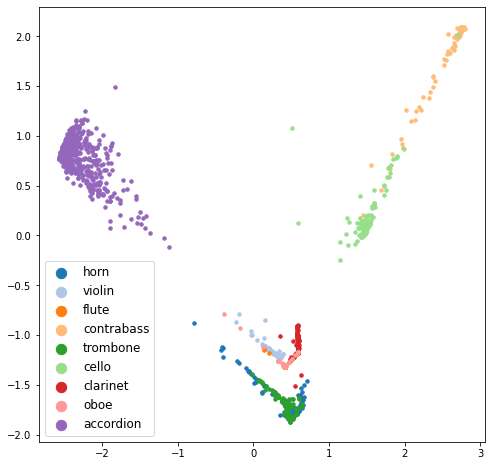

In [19]:
draw_pca(seen_tr_audio_embs, seen_tr_labels, seen_word_classes)

## 2. Unseen class prediction

In [20]:
unseen_word_audio_dataset_tr = WordAudioDataset(
    audio_path_list = unseen_audio_X_train,
    audio_label_list = unseen_audio_y_train,
    audio_transform = mel_transform,
    curr_word_classes = unseen_word_classes,
    word_emb_dict = inst_word_emb_dict
)
unseen_word_audio_dataset_ts = WordAudioDataset(
    audio_path_list = unseen_audio_X_test,
    audio_label_list = unseen_audio_y_test,
    audio_transform = mel_transform,
    curr_word_classes = unseen_word_classes,
    word_emb_dict = inst_word_emb_dict
)

In [21]:
unseen_word_audio_dataloaders = {}
unseen_word_audio_dataloaders['train'] = DataLoader(
    unseen_word_audio_dataset_tr,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)
unseen_word_audio_dataloaders['test'] = DataLoader(
    unseen_word_audio_dataset_ts,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)

In [22]:
(
    unseen_tr_audio_embs, 
    unseen_tr_word_embs, 
    unseen_tr_labels, 
    unseen_tr_loss
) = curr_model.infer_all(unseen_word_audio_dataloaders, 'train')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 592/592 [00:27<00:00, 21.44it/s]

train Loss: 0.4243


In [23]:
(
    unseen_ts_audio_embs, 
    unseen_ts_word_embs, 
    unseen_ts_labels, 
    unseen_ts_loss
) = curr_model.infer_all(unseen_word_audio_dataloaders, 'test')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:06<00:00, 21.36it/s]

test Loss: 0.4373


In [24]:
unseen_class_to_audio_embs, unseen_class_to_word_embs = defaultdict(list), defaultdict(list)
for i in tqdm(range(unseen_tr_audio_embs.shape[0])):
    unseen_class_to_audio_embs[unseen_tr_labels[i]].append(unseen_tr_audio_embs[i])
    unseen_class_to_word_embs[unseen_tr_labels[i]].append(unseen_tr_word_embs[i])

for i in range(len(list(unseen_class_to_audio_embs.keys()))):
    print(unseen_word_classes[i], len(unseen_class_to_audio_embs[i]), len(unseen_class_to_word_embs[i]))    
    
unseen_class_to_mean_audio_emb, unseen_class_to_mean_word_emb = {}, {}
for _c in unseen_class_to_audio_embs:
    unseen_class_to_mean_audio_emb[_c] = np.mean(unseen_class_to_audio_embs[_c], axis=0)
    unseen_class_to_mean_word_emb[_c] = unseen_class_to_word_embs[_c][0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 592/592 [00:00<00:00, 337780.98it/s]

bassoon 100 100
viola 248 248
trumpet 76 76
tuba 88 88
saxophone 80 80


### 2-1. Unseen audio to unseen word prediction (zero-shot evaluation)

In [25]:
correct = 0
for idx in range(unseen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
                                            unseen_class_to_mean_word_emb, 
                                            unseen_word_classes,
                                            1)
    if unseen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-1 acc : 0.3972602739726027


In [26]:
correct = 0
for idx in range(unseen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
                                            unseen_class_to_mean_word_emb, 
                                            unseen_word_classes,
                                            3)
    if unseen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-3 acc : 0.7123287671232876


In [42]:
correct = 0
for idx in range(unseen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
                                            unseen_class_to_mean_word_emb, 
                                            unseen_word_classes,
                                            1)
    if unseen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-1 acc : 0.2880658436213992


In [44]:
correct = 0
for idx in range(unseen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
                                            unseen_class_to_mean_word_emb, 
                                            unseen_word_classes,
                                            3)
    if unseen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-3 acc : 0.9917695473251029


In [38]:
# correct = 0
# for idx in range(unseen_ts_audio_embs.shape[0]):
#     curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
#                                             unseen_class_to_mean_word_emb, 
#                                             unseen_word_classes,
#                                             3)
#     if unseen_ts_labels[idx] in curr_pred_indices:
#         correct += 1
# print('Top-3 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-3 acc : 0.773109243697479


### 2-2. Unseen word to test set audio retrieval (zero-shot evaluation)

In [63]:
## TODO

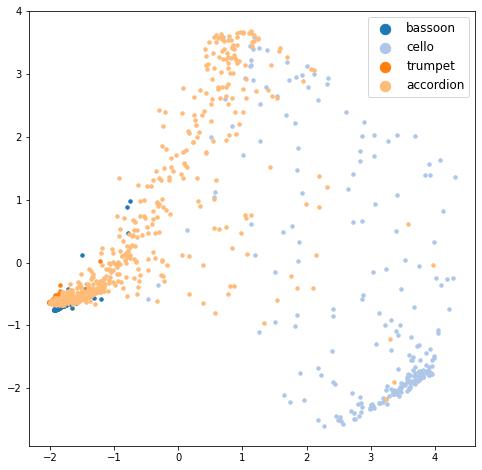

In [25]:
draw_pca(unseen_tr_audio_embs, unseen_tr_labels, unseen_word_classes)

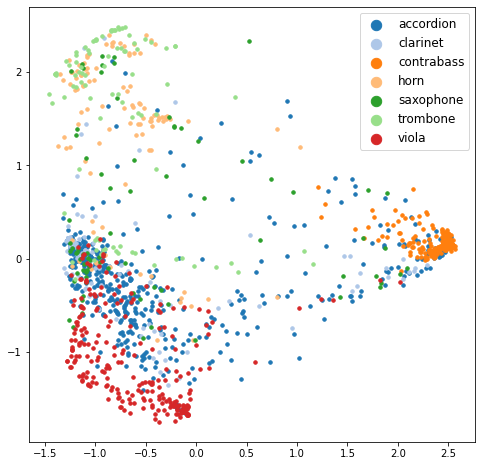

In [40]:
# draw_pca(unseen_tr_audio_embs, unseen_tr_labels, unseen_word_classes)

## Generalized ZSL evaluation

In [33]:
all_word_classes = seen_word_classes + unseen_word_classes

In [34]:
all_tr_audio_embs = np.concatenate([seen_tr_audio_embs, unseen_tr_audio_embs])
all_tr_word_embs = np.concatenate([seen_tr_word_embs, unseen_tr_word_embs])

In [35]:
added_unseen_tr_labels = [_n + 9 for _n in unseen_tr_labels]
added_unseen_ts_labels = [_n + 9 for _n in unseen_ts_labels]

In [36]:
all_tr_labels = seen_tr_labels + added_unseen_tr_labels

In [37]:
all_tr_audio_embs.shape[0], all_tr_word_embs.shape[0], len(all_tr_labels)

(2250, 2250, 2250)

In [38]:
all_class_to_audio_embs, all_class_to_word_embs = defaultdict(list), defaultdict(list)
all_class_to_audio_seen_word_embs, all_class_to_word_seen_audio_embs = defaultdict(list), defaultdict(list)

for i in tqdm(range(all_tr_audio_embs.shape[0])):
    all_class_to_audio_embs[all_tr_labels[i]].append(all_tr_audio_embs[i])
    all_class_to_word_embs[all_tr_labels[i]].append(all_tr_word_embs[i])

    all_class_to_audio_seen_word_embs[all_tr_labels[i]].append(all_tr_audio_embs[i])
    all_class_to_word_seen_audio_embs[all_tr_labels[i]].append(all_tr_word_embs[i])
    
for i in range(seen_tr_audio_embs.shape[0]):
    all_class_to_audio_seen_word_embs[seen_tr_labels[i]].append(seen_tr_word_embs[i])
    all_class_to_word_seen_audio_embs[seen_tr_labels[i]].append(seen_tr_audio_embs[i])

for i in range(len(list(all_class_to_audio_embs.keys()))):
    print(i, len(all_class_to_audio_embs[i]), len(all_class_to_word_embs[i]), len(all_class_to_audio_seen_word_embs[i]), len(all_class_to_word_seen_audio_embs[i]))
    
all_class_to_mean_audio_emb, all_class_to_mean_word_emb = {}, {}
for _c in all_class_to_audio_embs:
    all_class_to_mean_audio_emb[_c] = np.mean(all_class_to_audio_embs[_c], axis=0)
    all_class_to_mean_word_emb[_c] = np.mean(all_class_to_word_embs[_c], axis=0)
    
all_class_to_mean_audio_seen_word_emb, all_class_to_mean_word_seen_audio_emb = {}, {}
for _c in all_class_to_audio_seen_word_embs:
    all_class_to_mean_audio_seen_word_emb[_c] = np.mean(all_class_to_audio_seen_word_embs[_c], axis=0)
    all_class_to_mean_word_seen_audio_emb[_c] = np.mean(all_class_to_word_seen_audio_embs[_c], axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:00<00:00, 389934.06it/s]

0 108 108 216 216
1 228 228 456 456
2 96 96 192 192
3 247 247 494 494
4 92 92 184 184
5 248 248 496 496
6 100 100 200 200
7 88 88 176 176
8 84 84 168 168
9 100 100 100 100
10 232 232 232 232
11 76 76 76 76
12 551 551 551 551


### On unseen training set audio

In [39]:
correct = 0
for idx in range(unseen_tr_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_tr_audio_embs[idx], 0), 
                                            all_class_to_mean_word_emb, 
                                            all_word_classes,
                                            3)
    if added_unseen_tr_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / unseen_tr_audio_embs.shape[0])

Top-3 acc : 0.2492179353493222


In [50]:
# correct = 0
# for idx in range(unseen_tr_audio_embs.shape[0]):
#     curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_tr_audio_embs[idx], 0), 
#                                             all_class_to_mean_word_emb, 
#                                             all_word_classes,
#                                             3)
#     if added_unseen_tr_labels[idx] in curr_pred_indices:
#         correct += 1
# print('Top-3 acc :', correct / unseen_tr_audio_embs.shape[0])

Top-3 acc : 0.520336605890603


### On unseen test set audio

In [40]:
correct = 0
for idx in range(unseen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
                                            all_class_to_mean_word_emb, 
                                            all_word_classes,
                                            3)
    if added_unseen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-3 acc : 0.17695473251028807


In [49]:
# correct = 0
# for idx in range(unseen_ts_audio_embs.shape[0]):
#     curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
#                                             all_class_to_mean_word_emb, 
#                                             all_word_classes,
#                                             3)
#     if added_unseen_ts_labels[idx] in curr_pred_indices:
#         correct += 1
# print('Top-3 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-3 acc : 0.6050420168067226


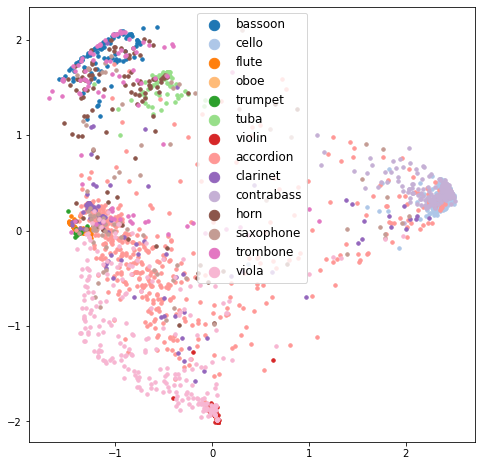

In [55]:
draw_pca(all_tr_audio_embs, all_tr_labels, all_word_classes)

## Seen + unseen class embedding 

In [56]:
with open('./data/inst_glove_vector.p', 'rb') as f:
    inst_word_emb_dict = pickle.load(f)

In [57]:
inst_word_embeddings, inst_word_classes = [], []
for word, emb in inst_word_emb_dict.items():
    inst_word_embeddings.append(emb)
    inst_word_classes.append(word)

In [60]:
zsl_word_embeddings, zsl_word_classes = [], []
for word_idx in range(7):
    for k in range(len(seen_ts_labels)):
        if seen_ts_labels[k] == word_idx:
            zsl_word_embeddings.append(seen_ts_word_embs[k])
            zsl_word_classes.append(seen_word_classes[word_idx])
            break
for word_idx in range(7):
    for k in range(len(unseen_ts_labels)):
        if unseen_ts_labels[k] == word_idx:
            zsl_word_embeddings.append(unseen_ts_word_embs[k])
            zsl_word_classes.append(unseen_word_classes[word_idx])
            break
zsl_word_embeddings = np.array(zsl_word_embeddings)

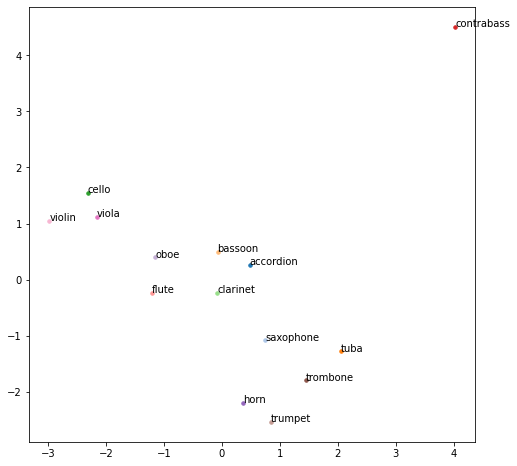

In [58]:
draw_pca_with_class(inst_word_embeddings, list(range(14)), inst_word_classes)

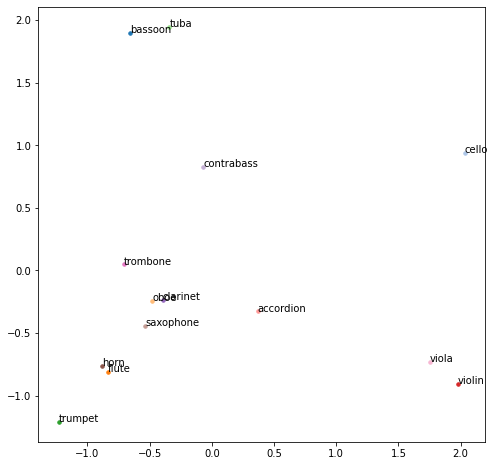

In [61]:
draw_pca_with_class(zsl_word_embeddings, list(range(14)), all_word_classes)